In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [2]:
import sys
sys.path.append("../..")

from adversarial_ntks import attacks, jsvc

# Data generation

Our data in labeled by $Y \in \{0, 1\}$,
and $X | Y \sim \mathcal{N}(0, \sigma_Y \cdot I_d)$.

In [3]:
def generate_normal_data(dim, s0, s1, num_samples):
    assert num_samples % 2 == 0
    assert s0 <= s1
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    xs = np.concatenate([
        np.random.normal(scale=s0, size=(num_samples // 2, dim)),
        np.random.normal(scale=s1, size=(num_samples // 2, dim))
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def radial_attack(
    xs: np.ndarray, ys: np.ndarray,
    attack_norm, attack_eps,
):
    norm_xs = normalize(xs, norm=attack_norm)
    
    adv_xs = xs.copy()
    adv_xs[ys == 0] += attack_eps * norm_xs[ys == 0]
    adv_xs[ys == 1] -= attack_eps * norm_xs[ys == 1]
    
    return adv_xs

xs, ys = generate_normal_data(dim=2, s0=0.3, s1=0.7, num_samples=4)
radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1)

array([[ 0.05495964, -1.65815198],
       [ 0.08483867,  0.5164537 ],
       [ 0.32682863,  0.38050427],
       [-0.65236533,  0.35630801]])

## Some utilities

In [4]:
def accs_by_cls(preds, ys):
    return (preds[ys == 0] == 0).mean(), (preds[ys == 1] == 1).mean()

def fmt_accs(accs):
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

# Experiments

In [5]:
RESULTS = dict() # used to store experiment artifacts

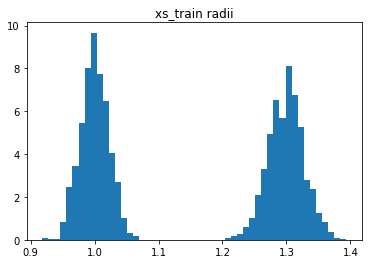

In [6]:
dim = 1000
s0, s1 = 1.0 / np.sqrt(dim), 1.3 / np.sqrt(dim)

xs_train, ys_train = generate_normal_data(
    dim=dim, s0=s0, s1=s1, num_samples=2000,
)
xs_test, ys_test = generate_normal_data(
    dim=dim, s0=s0, s1=s1, num_samples=1000,
)

plt.title("xs_train radii")
plt.hist(np.linalg.norm(xs_train, ord=2, axis=-1), density=True, bins=50);

## Kernel SVM

See https://scikit-learn.org/stable/modules/svm.html#svc to check that the formulation below matches the sklearn specs.

Let $(x_1, y_1), \ldots, (x_n, y_n) \in \mathcal{X} \times \{\pm 1\}$ be training data.

A binary kernel classifier $f_{\alpha, b}: \mathcal{X} \to \{\pm 1\}$ parameterized by
$\alpha, b \in \mathbb{R}^n \times \mathbb{R}$
and with kernel $k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ acts as

$$
f_{\alpha, b}(x) = \mathrm{sgn} \left( \sum_{i = 1}^n \alpha_i \, k(x_i, x) + b \right).
$$

For a SVM, $\alpha$ and $b$ are found via empirical risk minimization on the regularized hinge loss:

$$
\underset{\alpha, \,b \,\in\, \mathbb{R}^d \times \mathbb{R}}{\mathrm{argmin}} \quad
\sum_{i = 1}^n \max(0, 1 - y_i f_\alpha(x_i)) +
\frac{1}{2C} \sum_{i = 1}^n \sum_{j = 1}^n \alpha_i \, \alpha_j \, k(x_i, x_j)
$$

Here $C$ inversely controls the strength of regularization, i.e. large $C$ means no regularization.
However note that $C$ does not automatically scale with $n$.

### Notes
For theoretical analysis, we could drop the bias term since we can incorporate it into the kernel.

In [7]:
def eval_svm_clf(
    clf: svm.SVC,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    verbose: bool = True,
    label: str = "",
):
    if verbose:
        print(f"{label}; n_support={clf.n_support_}; b={clf.intercept_}")
    
    accs_train = accs_by_cls(preds=clf.predict(xs_train), ys=ys_train)
    accs_test = accs_by_cls(preds=clf.predict(xs_test), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train={fmt_accs(accs_train)}; accs_test={fmt_accs(accs_test)}")
    
    xs_train_arad = radial_attack(xs=xs_train, ys=ys_train, attack_norm=2, attack_eps=attack_eps)
    xs_test_arad = radial_attack(xs=xs_test, ys=ys_test, attack_norm=2, attack_eps=attack_eps)
    accs_train_arad = accs_by_cls(preds=clf.predict(xs_train_arad), ys=ys_train)
    accs_test_arad = accs_by_cls(preds=clf.predict(xs_test_arad), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train_arad={fmt_accs(accs_train_arad)}; accs_test_arad={fmt_accs(accs_test_arad)}")
    
    xs_train_pgd = attacks.pgd(
        X=jnp.array(xs_train), Y=jnp.array(ys_train),
        grad_func=lambda X: jsvc.grad_decision_function(clf, X),
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=False,
    )
    xs_test_pgd = attacks.pgd(
        X=jnp.array(xs_test), Y=jnp.array(ys_test),
        grad_func=lambda X: jsvc.grad_decision_function(clf, X),
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=False,
    )
    accs_train_pgd = accs_by_cls(preds=clf.predict(xs_train_pgd), ys=ys_train)
    accs_test_pgd = accs_by_cls(preds=clf.predict(xs_test_pgd), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train_pgd={fmt_accs(accs_train_pgd)}; accs_test_pgd={fmt_accs(accs_test_pgd)}")

    return dict(
        accs_train=accs_train,
        accs_test=accs_test,
        attack_eps=attack_eps,
        accs_train_arad=accs_train_arad,
        accs_test_arad=accs_test_arad,
        accs_train_pgd=accs_train_pgd,
        accs_test_pgd=accs_test_pgd,
        xs_train_pgd=xs_train_pgd,
        xs_test_pgd=xs_test_pgd,
    )

### Poly, deg=2

In [8]:
%%time
RESULTS["svm-poly"] = []
for c in [1e-4, 1e-2, 1, 100]:
    clf = svm.SVC(kernel="poly", degree=2, coef0=1, C=c)
    clf.fit(xs_train, ys_train)

    res_dict = dict(clf=clf)
    res_dict.update(
        eval_svm_clf(
            clf=clf,
            label=f"C={c}",
            attack_eps=0.1,
            pgd_step_size=0.1/10,
            pgd_num_steps=20,
        )
    )

    RESULTS["svm-poly"].append(res_dict)

C=0.0001; n_support=[1000 1000]; b=[-0.00021592]
C=0.0001; accs_train=(0.9400, 0.7980); accs_test=(0.7500, 0.3040)
C=0.0001; accs_train_arad=(0.9340, 0.7650); accs_test_arad=(0.7160, 0.2820)
C=0.0001; accs_train_pgd=(0.0600, 0.0440); accs_test_pgd=(0.0140, 0.0100)
C=0.01; n_support=[1000 1000]; b=[-0.02159225]
C=0.01; accs_train=(0.9400, 0.7980); accs_test=(0.7500, 0.3040)
C=0.01; accs_train_arad=(0.9340, 0.7650); accs_test_arad=(0.7160, 0.2820)
C=0.01; accs_train_pgd=(0.0600, 0.0440); accs_test_pgd=(0.0140, 0.0100)
C=1; n_support=[871 980]; b=[-0.63833934]
C=1; accs_train=(0.9980, 0.9990); accs_test=(0.7800, 0.3140)
C=1; accs_train_arad=(0.9980, 0.9990); accs_test_arad=(0.7540, 0.2720)
C=1; accs_train_pgd=(0.0090, 0.0020); accs_test_pgd=(0.0080, 0.0060)
C=100; n_support=[860 983]; b=[-0.69085282]
C=100; accs_train=(1.0000, 1.0000); accs_test=(0.8200, 0.3120)
C=100; accs_train_arad=(1.0000, 1.0000); accs_test_arad=(0.7640, 0.2580)
C=100; accs_train_pgd=(0.0120, 0.0020); accs_test_pgd=(

### RBF

In [9]:
%%time
attack_eps = 0.1

RESULTS["svm-rbf"] = []
for c in [1e-4, 1e-2, 1, 1e2, 1e4]:
    clf = svm.SVC(kernel="rbf", C=c)
    clf.fit(xs_train, ys_train)
    
    res_dict = dict(clf=clf)
    res_dict.update(
        eval_svm_clf(
            clf=clf,
            label=f"C={c}",
            attack_eps=0.1,
            pgd_step_size=0.1/10,
            pgd_num_steps=20,
        )
    )

    RESULTS["svm-rbf"].append(res_dict)

C=0.0001; n_support=[1000 1000]; b=[0.0073058]
C=0.0001; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=0.0001; accs_train_arad=(0.9770, 0.9910); accs_test_arad=(0.9500, 0.9840)
C=0.0001; accs_train_pgd=(0.9770, 0.9910); accs_test_pgd=(0.9500, 0.9840)
C=0.01; n_support=[1000 1000]; b=[0.73058003]
C=0.01; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=0.01; accs_train_arad=(0.9770, 0.9910); accs_test_arad=(0.9500, 0.9840)
C=0.01; accs_train_pgd=(0.9770, 0.9910); accs_test_pgd=(0.9500, 0.9840)
C=1; n_support=[424 447]; b=[4.09425553]
C=1; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=1; accs_train_arad=(1.0000, 1.0000); accs_test_arad=(0.9540, 0.9740)
C=1; accs_train_pgd=(1.0000, 1.0000); accs_test_pgd=(0.9520, 0.9740)
C=100.0; n_support=[424 447]; b=[4.09427757]
C=100.0; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=100.0; accs_train_arad=(1.0000, 1.0000); accs_test_arad=(0.9540, 0.9740)
C=100.0; accs_train_pgd=(1.0000, 1.0000); accs_test_pg

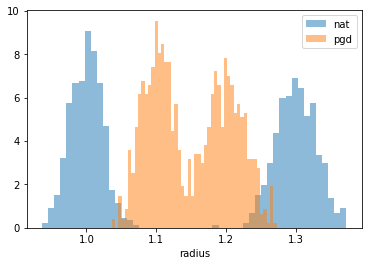

In [11]:
plt.hist(np.linalg.norm(xs_test, ord=2, axis=-1), density=True, bins=50, alpha=0.5, label="nat");
plt.hist(np.linalg.norm(RESULTS["svm-rbf"][0]["xs_test_pgd"], ord=2, axis=-1), density=True, bins=50, alpha=0.5, label="pgd");
plt.xlabel("radius");
plt.legend();

## Kernel regression

Todo.